# AGDCv2 Landsat analytics example using USGS Surface Reflectance

### Import the required libraries

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import datacube
from datacube.model import Range
from datetime import datetime
dc = datacube.Datacube(app='dc-example')
from datacube.storage import masking
from datacube.storage.masking import mask_valid_data as mask_invalid_data
import pandas
import xarray
import numpy
import json
import vega
from datacube.utils import geometry
numpy.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
import folium
from IPython.display import display
import geopandas
from shapely.geometry import mapping
from shapely.geometry import MultiPolygon
import rasterio
import shapely.geometry
import shapely.ops
from functools import partial
import pyproj
from datacube.model import CRS
from datacube.utils import geometry

In [3]:
## From http://scikit-image.org/docs/dev/auto_examples/plot_equalize.html
from skimage import data, img_as_float
from skimage import exposure

In [4]:
datacube.__version__

'1.1.17'

### Include some helpful functions

In [5]:
def datasets_union(dss):
    thing = geometry.unary_union(ds.extent for ds in dss)
    return thing.to_crs(geometry.CRS('EPSG:4326'))

In [6]:
import random
def plot_folium(shapes):

    mapa = folium.Map(location=[17.38,78.48], zoom_start=8)
    colors=['#00ff00', '#ff0000', '#00ffff', '#ffffff', '#000000', '#ff00ff']
    for shape in shapes:
        style_function = lambda x: {'fillColor': '#000000' if x['type'] == 'Polygon' else '#00ff00', 
                                   'color' : random.choice(colors)}
        poly = folium.features.GeoJson(mapping(shape), style_function=style_function)
        mapa.add_children(poly)
    display(mapa)

In [7]:
# determine the clip parameters for a target clear (cloud free image) - identified through the index provided
def get_p2_p98(rgb, red, green, blue, index):

    r = numpy.nan_to_num(numpy.array(rgb.data_vars[red][index]))
    g = numpy.nan_to_num(numpy.array(rgb.data_vars[green][index]))
    b = numpy.nan_to_num(numpy.array(rgb.data_vars[blue][index]))
  
    rp2, rp98 = numpy.percentile(r, (2, 99))
    gp2, gp98 = numpy.percentile(g, (2, 99)) 
    bp2, bp98 = numpy.percentile(b, (2, 99))

    return(rp2, rp98, gp2, gp98, bp2, bp98)

In [8]:
def plot_rgb(rgb, rp2, rp98, gp2, gp98, bp2, bp98, red, green, blue, index):

    r = numpy.nan_to_num(numpy.array(rgb.data_vars[red][index]))
    g = numpy.nan_to_num(numpy.array(rgb.data_vars[green][index]))
    b = numpy.nan_to_num(numpy.array(rgb.data_vars[blue][index]))

    r_rescale = exposure.rescale_intensity(r, in_range=(rp2, rp98))
    g_rescale = exposure.rescale_intensity(g, in_range=(gp2, gp98))
    b_rescale = exposure.rescale_intensity(b, in_range=(bp2, bp98))

    rgb_stack = numpy.dstack((r_rescale,g_rescale,b_rescale))
    img = img_as_float(rgb_stack)

    return(img)

In [9]:
def plot_water_pixel_drill(water_drill):
    vega_data = [{'x': str(ts), 'y': str(v)} for ts, v in zip(water_drill.time.values, water_drill.values)]
    vega_spec = """{"width":720,"height":90,"padding":{"top":10,"left":80,"bottom":60,"right":30},"data":[{"name":"wofs","values":[{"code":0,"class":"dry","display":"Dry","color":"#D99694","y_top":30,"y_bottom":50},{"code":1,"class":"nodata","display":"No Data","color":"#A0A0A0","y_top":60,"y_bottom":80},{"code":2,"class":"shadow","display":"Shadow","color":"#A0A0A0","y_top":60,"y_bottom":80},{"code":4,"class":"cloud","display":"Cloud","color":"#A0A0A0","y_top":60,"y_bottom":80},{"code":1,"class":"wet","display":"Wet","color":"#4F81BD","y_top":0,"y_bottom":20},{"code":3,"class":"snow","display":"Snow","color":"#4F81BD","y_top":0,"y_bottom":20},{"code":255,"class":"fill","display":"Fill","color":"#4F81BD","y_top":0,"y_bottom":20}]},{"name":"table","format":{"type":"json","parse":{"x":"date"}},"values":[],"transform":[{"type":"lookup","on":"wofs","onKey":"code","keys":["y"],"as":["class"],"default":null},{"type":"filter","test":"datum.y != 255"}]}],"scales":[{"name":"x","type":"time","range":"width","domain":{"data":"table","field":"x"},"round":true},{"name":"y","type":"ordinal","range":"height","domain":["water","not water","not observed"],"nice":true}],"axes":[{"type":"x","scale":"x","formatType":"time"},{"type":"y","scale":"y","tickSize":0}],"marks":[{"description":"data plot","type":"rect","from":{"data":"table"},"properties":{"enter":{"xc":{"scale":"x","field":"x"},"width":{"value":"1"},"y":{"field":"class.y_top"},"y2":{"field":"class.y_bottom"},"fill":{"field":"class.color"},"strokeOpacity":{"value":"0"}}}}]}"""
    spec_obj = json.loads(vega_spec)
    spec_obj['data'][1]['values'] = vega_data
    return vega.Vega(spec_obj)

## Plot the spatial extent of our data for each product

In [10]:
plot_folium([datasets_union(dc.index.datasets.search_eager(product='ls5_ledaps_scene')),\
             datasets_union(dc.index.datasets.search_eager(product='ls7_ledaps_scene')),\
             datasets_union(dc.index.datasets.search_eager(product='ls8_ledaps_scene'))])

## Inspect the available measurements for each product

In [11]:
dc.list_measurements()

aliases  dtype  \
product          measurement                                                   
ls5_ledaps_scene blue                                  [band_1, blue]  int16   
                 green                                [band_2, green]  int16   
                 red                                    [band_3, red]  int16   
                 nir                                    [band_4, nir]  int16   
                 swir1                                [band_5, swir1]  int16   
                 swir2                                [band_7, swir2]  int16   
                 cfmask                                [mask, CFmask]  uint8   
                 cfmask_conf                            [mask_config]  uint8   
                 sr_adjacent_cloud_qa                [adjacent_cloud]  uint8   
                 sr_atmos_opacity      [atmospheric_opacity, opacity]  int16   
                 sr_cloud_qa                                  [cloud]  uint8   
                 sr_cloud_shadow_qa                    [cloud_shadow]  uint8   
                 sr_ddv_qa                                      [ddv]  uint8   
                 sr_fill_qa                                    [fill]  uint8   
                 sr_land_water_qa                        [land_water]  uint8   
                 sr_snow_qa                                    [snow]  uint8   
ls5_nbar_scene   1                                     [band_1, blue]  int16   
                 2                                    [band_2, green]  int16   
                 3                                      [band_3, red]  int16   
                 4                                      [band_4, nir]  int16   
                 5                                    [band_5, swir1]  int16   
                 7                                    [band_7, swir2]  int16   
ls5_nbart_scene  1                                     [band_1, blue]  int16   
                 2                                    [band_2, green]  int16   
                 3                                      [band_3, red]  int16   
                 4                                      [band_4, nir]  int16   
                 5                                    [band_5, swir1]  int16   
                 7                                    [band_7, swir2]  int16   
ls5_pq_scene     pqa                              [qa_flags, quality]  int16   
ls7_ledaps_scene blue                                  [band_1, blue]  int16   
...                                                               ...    ...   
ls7_nbart_scene  3                                      [band_3, red]  int16   
                 4                                      [band_4, nir]  int16   
                 5                                    [band_5, swir1]  int16   
                 7                                    [band_7, swir2]  int16   
ls7_pq_scene     pqa                              [qa_flags, quality]  int16   
ls8_ledaps_scene coastal_aerosol            [band_1, coastal_aerosol]  int16   
                 blue                                  [band_2, blue]  int16   
                 green                                [band_3, green]  int16   
                 red                                    [band_4, red]  int16   
                 nir                                    [band_5, nir]  int16   
                 swir1                                [band_6, swir1]  int16   
                 swir2                                [band_7, swir2]  int16   
                 cfmask                                [mask, CFmask]  uint8   
                 cfmask_conf                            [mask_config]  uint8   
                 sr_cloud                                     [cloud]  uint8   
ls8_nbar_scene   1                          [band_1, coastal_aerosol]  int16   
                 2                                     [band_2, blue]  int16   
                 3                                    [band_3,

## Specify the Area of Interest for our analysis

In [12]:
# Hyderbad
#    'lon': (78.40, 78.57),
#    'lat': (17.36, 17.52),
# Lake Singur
#    'lat': (17.67, 17.84),
#    'lon': (77.83, 78.0),

# Lake Singur Dam
query = {
    'lat': (17.72, 17.79),
    'lon': (77.88, 77.95),
}

## Load Landsat Surface Reflectance for our Area of Interest

In [13]:
products = ['ls5_ledaps_scene','ls7_ledaps_scene','ls8_ledaps_scene']

datasets = []
for product in products:
    ds = dc.load(product=product, measurements=['nir','red', 'green','blue'], output_crs='EPSG:32644',resolution=(-30,30), **query)
    ds['product'] = ('time', numpy.repeat(product, ds.time.size))
    datasets.append(ds)

sr = xarray.concat(datasets, dim='time')
sr = sr.isel(time=sr.time.argsort())  # sort along time dim
sr = sr.where(sr != -9999)

In [14]:
##### include an index here for the timeslice with representative data for best stretch of time series

# don't run this to keep the same limits as the previous sensor
#rp2, rp98, gp2, gp98, bp2, bp98 = get_p2_p98(sr,'red','green','blue', 0)

rp2, rp98, gp2, gp98, bp2, bp98 = (300.0, 2000.0, 300.0, 2000.0, 300.0, 2000.0)
print(rp2, rp98, gp2, gp98, bp2, bp98)

300.0 2000.0 300.0 2000.0 300.0 2000.0


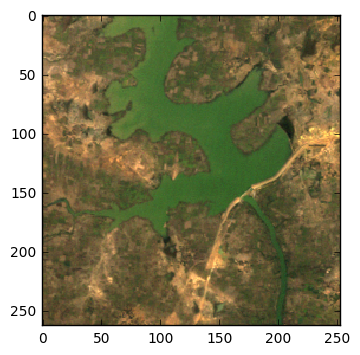

In [15]:
plt.imshow(plot_rgb(sr,rp2, rp98, gp2, gp98, bp2, bp98,'red',
                        'green', 'blue', 0),interpolation='nearest')

## Load Landsat Pixel Quality for our area of interest

In [16]:
datasets = []
for product in products:
    ds = dc.load(product=product, measurements=['cfmask'], output_crs='EPSG:32644',resolution=(-30,30), **query).cfmask
    ds['product'] = ('time', numpy.repeat(product, ds.time.size))
    datasets.append(ds)

pq = xarray.concat(datasets, dim='time')
pq = pq.isel(time=pq.time.argsort())  # sort along time dim
del(datasets)

## Visualise pixel quality information from our selected spatiotemporal subset

In [17]:
pq.attrs['flags_definition'] = {'cfmask': {'values': {'255': 'fill', '1': 'water', '2': 'shadow', '3': 'snow', '4': 'cloud', '0': 'clear'}, 'description': 'CFmask', 'bits': [0, 1, 2, 3, 4, 5, 6, 7]}}

In [18]:
pandas.DataFrame.from_dict(masking.get_flags_def(pq), orient='index')

,values,description,bits
cfmask,"{'255': 'fill', '3': 'snow', '2': 'shadow', '0...",CFmask,"[0, 1, 2, 3, 4, 5, 6, 7]"


### Plot the frequency of water classified in pixel quality 

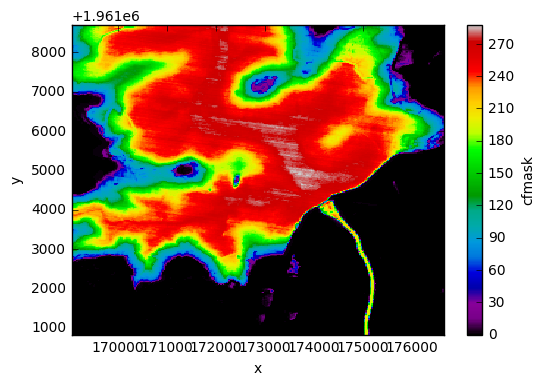

In [19]:
water = masking.make_mask(pq, cfmask ='water')
water.sum('time').plot(cmap='nipy_spectral')

### Plot the timeseries at the center point of the image

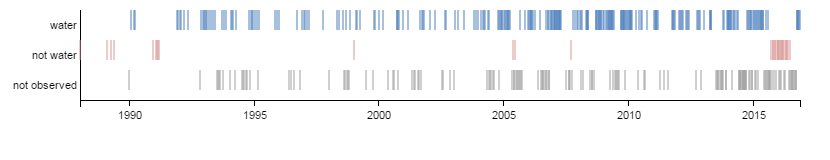

In [20]:
plot_water_pixel_drill(pq.isel(y=int(water.shape[1] / 2), x=int(water.shape[2] / 2)))

In [21]:
del(water)

## Remove the cloud and shadow pixels from the surface reflectance

In [22]:
mask = masking.make_mask(pq, cfmask ='cloud')
mask = abs(mask*-1+1)
sr = sr.where(mask)
mask = masking.make_mask(pq, cfmask ='shadow')
mask = abs(mask*-1+1)
sr = sr.where(mask)
del(mask)
del(pq)

In [23]:
sr.attrs['crs'] = CRS('EPSG:32644')

## Spatiotemporal summary NDVI median

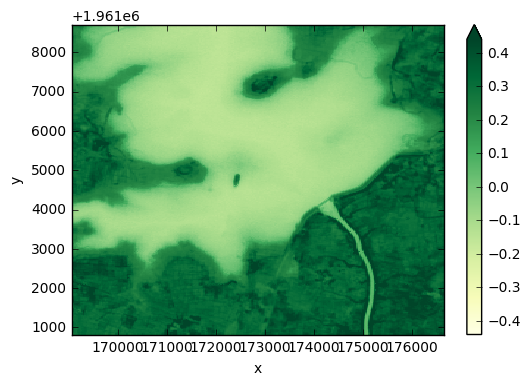

In [24]:
ndvi_median = ((sr.nir-sr.red)/(sr.nir+sr.red)).median(dim='time')
ndvi_median.attrs['crs'] = CRS('EPSG:32644')
ndvi_median.plot(cmap='YlGn', robust='True')

## NDVI trend over time in cropping area Point Of Interest

In [25]:
poi_latitude = 17.749343
poi_longitude = 77.935634

In [26]:
p = geometry.point(x=poi_longitude, y=poi_latitude, crs=geometry.CRS('EPSG:4326')).to_crs(sr.crs)

### Create a subset around our point of interest

In [27]:
subset = sr.sel(x=((sr.x > p.points[0][0]-1000)), y=((sr.y < p.points[0][1]+1000)))
subset = subset.sel(x=((subset.x < p.points[0][0]+1000)), y=((subset.y > p.points[0][1]-1000)))

### Plot subset image with POI at centre

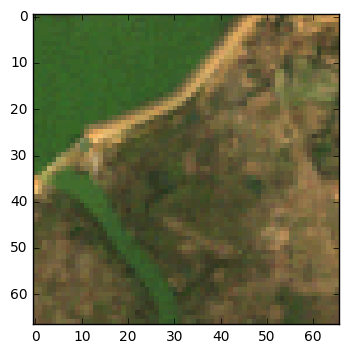

In [28]:
plt.imshow(plot_rgb(subset,rp2, rp98, gp2, gp98, bp2, bp98,'red',
                        'green', 'blue',0),interpolation='nearest' )

### NDVI timeseries plot

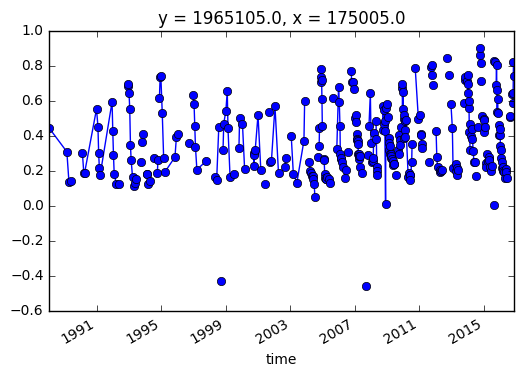

In [29]:
((sr.nir-sr.red)/(sr.nir+sr.red)).sel(x=p.points[0][0], y=p.points[0][1], method='nearest').plot(marker='o')